<a href="https://colab.research.google.com/github/gcorani/bda/blob/main/nbooks/2_ProbProgramming_normal_normal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pymc as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import t
from scipy.stats import norm
import seaborn as sns
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [7,3],
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0,
})
sns.set(rc={'figure.figsize':(7,3)})

# Normal-normal models  in probabilistic programming


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on..


*   Chapter 2 of O. Martin, *Bayesian Analysis with Python, Second Edition*.

*  Notebook by G. Corani

# Normal - normal model


\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu})  && \text{prior uncertainty on } \mu\\
\sigma & \sim \text{HalfNormal} (\xi) &&  \text{prior uncertainty on } \sigma\\
\vec{y} & \sim N(\mu, \sigma) && \text{distribution of the data given } \mu \text{ and } \sigma \\
\end{align*}

* The observations $\vec{y}=\{y_1,y_2,y_n\}$ are assumed to be independent.


# Inference about the speed of light

* At the end of the 19th century  Newcomb carried out several experiments to determine the speed of light.

* He measured 66 times how much time it took for the light to travel a certain distance.

* The reported data are the time in millionths of a second for light to traverse a known distance.

* Based on  theory,  he expected the travel time to be within (246,  250).
We formalize this with the prior $\mu \sim N(248,1)$.

* He estimates his measuring tools to yield to have a precision of +- 0.2.
We formalize this by choosing the scale of the NH so that the median is about 0.2.
     

In [3]:
#Below  the  66 measurements.

data = np.array([248.28, 248.26, 248.33, 248.24, 248.34, 247.56, 248.27, 248.16,
                  248.4, 247.98, 248.29, 248.22, 248.24, 248.21, 248.25, 248.3,
                  248.23, 248.29, 248.31, 248.19, 248.24, 248.2, 248.36, 248.32,
                  248.36, 248.28, 248.25, 248.21, 248.28, 248.29, 248.37, 248.25,
                  248.28, 248.26, 248.3, 248.32, 248.36, 248.26, 248.3, 248.22,
                  248.36, 248.23, 248.27, 248.27, 248.28, 248.27, 248.31, 248.27,
                  248.26, 248.33, 248.26, 248.32, 248.32, 248.24, 248.39, 248.28,
                  248.24, 248.25, 248.32, 248.25, 248.29, 248.27, 248.28, 248.29,
                  248.16, 248.23])

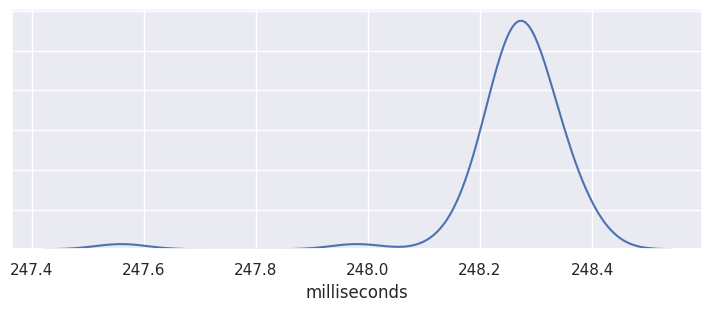

In [4]:
# The data are almost  normally distributed, apart from some  low-values outliers  which are far from the mean.
#the density plot is called kde (kernel density estimation)
sns.kdeplot(data)
plt.gca().set_yticklabels([])
plt.xlabel('milliseconds')
plt.ylabel('');

In [5]:
#tune the halfnormal prior to have a median close to 0.2, the plausible value of sigma a priori.
from scipy.stats import halfnorm

#scale of the half-normal obtained after some trial and error
halfnorm.median(scale=0.3) #0.2

np.float64(0.2023469250588245)

In [6]:
with pm.Model() as normal_model:
    # The prior information from the theory is represented by a N(248, 1).
    mu = pm.Normal('mu', 248, 1)

    # By using a  scale parameter of 3, the median  of the halfnormal is close to 2.,
    sigma = pm.HalfNormal('sigma', 0.3)


    #likelihood. The observation are stored in vector 'data'.
    #and assumed to be independent.
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)

    normal_trace = pm.sample()

Output()

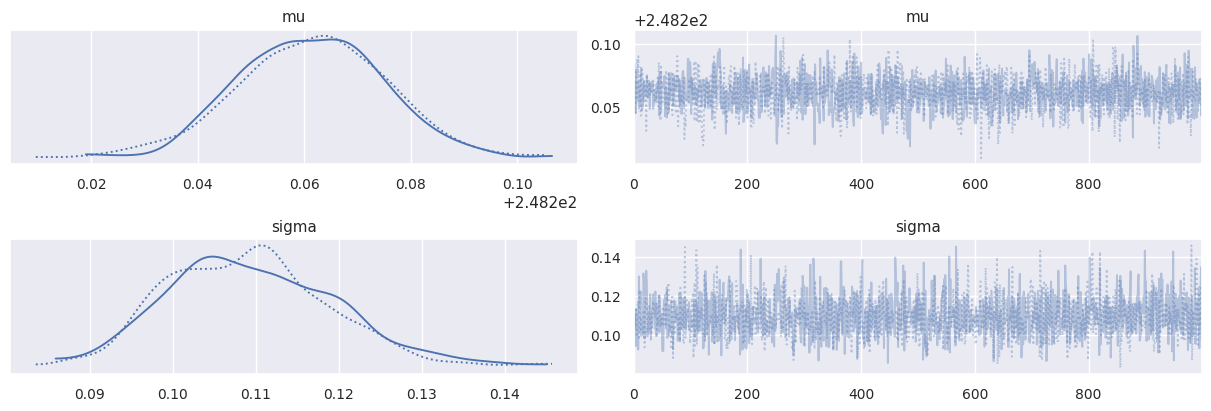

In [7]:
# The  density plots of  both parameters are smooth and the chains are well-mixing.

with  normal_model:
    az.plot_trace(normal_trace)

In [8]:
# The  density plots of  both parameters are smooth and the chains are well-mixing.
az.summary(normal_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.261,0.014,248.235,248.286,0.0,0.0,1490.0,1099.0,1.0
sigma,0.109,0.010,0.092,0.129,0.0,0.0,2115.0,1582.0,1.0


# Prior sensitivity

* We now test with a different prior, assuming the travel time to be within (200, 300). Recall that before we had instead a more informative prior, referring to the interval (246,  250).

* We refer to this as a *weak* prior.

* The prior on sigma is not changed.


In [9]:
with pm.Model() as model_weak_prior:

    mu = pm.Normal('mu', 250, 25)

    #identical to the previous model
    sigma = pm.HalfNormal('sigma', 0.3)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)

    trace_weak_prior = pm.sample(return_inferencedata=True)

Output()

In [10]:
# The posterior is practically identical under the two different priors.
# This is  good: the data are strong enough to converge to the same posterior.
# The likelihood overwhelms the prior; the results are thus robust to the specification of the prior.
pd.concat( [az.summary(normal_trace), az.summary(trace_weak_prior)] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,248.261,0.014,248.235,248.286,0.0,0.0,1490.0,1099.0,1.0
sigma,0.109,0.010,0.092,0.129,0.0,0.0,2115.0,1582.0,1.0
mu,248.262,0.014,248.237,248.287,0.0,0.0,2107.0,1546.0,1.0
sigma,0.110,0.010,0.091,0.127,0.0,0.0,2079.0,1298.0,1.0


# Predictions

# Point prediction

* How to make a prediction about the next measurement $y^{\text{new}}$?


* The simplest answer is to use the posterior mean (248.262, see previous slide). Recall that the posterior mean is compromise between the prior mean and the sample mean. However this is a **point prediction** without quantification of the uncertainty.


#  Predictive distribution

To model the uncertainty, we compute a distribution (*predictive distribution*) for the next observation. We denote the next observation by $y^{\text{new}}$.

The predictive distribution accounts for

*  the *epistemic* uncertainty about $\mu$ and  $\sigma$, i.e., the fact that we are unsure about the actual value of them;

* the *aleatory* uncertainty, i.e., the randomness of sampling from a normal distribution, even if  know exactly $\mu$ and $\sigma$.

# Computing the predictive distribution

* The trace contains e.g. 4000  samples, i.e., 4000 values of $\mu$ and $\sigma$ from the posterior.

* We denote the $s$-th  sample  $<\mu_s, \sigma_s >$ (a sample contains a value for each parameter)


# Computing the predictive distribution

* We compute a  prediction from  each  sample:

$$
\left[
\begin{array}{ll}
\mu_1 &   \sigma_1 \\
\mu_2 & \sigma_2 \\
\vdots & \vdots  \\
\mu_{4000}  & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y^{\text{new}}_{1} \\
y^{\text{new}}_{2} \\
\vdots \\
y^{\text{new}}_{4000} \\
\end{array}
\right]
$$

with:

$$y^{\text{new}}_{s} \; \sim \; N\left(\mu_s, \sigma_s\right)$$


* The  4,000 drawn values of $y_{\text{new}}$ are the *predictive* distribution of a new measurement.

# Computing the predictive distribution

In [11]:
#extract the posterior samples of mu and sigma
post_samples = az.extract(normal_trace.posterior)
mu_post      = post_samples.mu.values
sigma_post   = post_samples.sigma.values

# we draw five values for each pair of mu and sigma values.
# This provides  a smoother predictive distribution.
s = 5 #number of y_new sampled  for each element of the trace.
y_new = np.zeros( len(mu_post) * s)

#we should use together  the values of sigma e mu referring to the same sample
for i in range(len(mu_post)):
        y_new[i*s : (i+1) * s] = np.random.normal (loc = mu_post[i], scale = sigma_post[i], size=s)


mean: 248.261
95% hdi: [248.041 , 248.48 ]


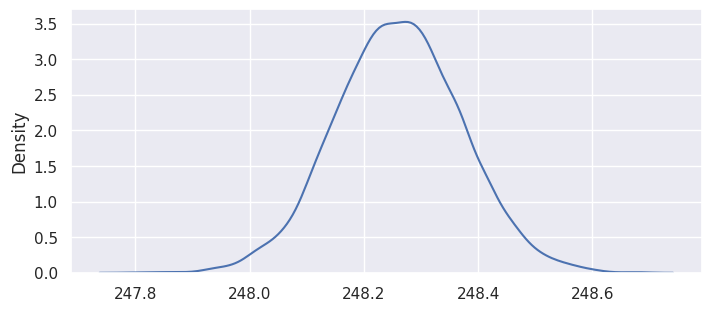

In [12]:
# plot and summarize the predictive distribution
sns.kdeplot(y_new)

# since the distribution is symmetric, the 95% HDI is obtained by taking the 2.5 and 97.5 quantile
hdi = [np.quantile(y_new, 0.025), np.quantile(y_new, 0.975)]
pred_mean = np.mean(y_new)
print("mean: " + str(round(pred_mean,3)))
print("95% hdi: [" + str(round(hdi[0],3)) + " , " + str(round(hdi[1],3)) + " ]")

In [13]:
# posterior samples are stored as xarray, which is library  of multidimensional arrays with labelling.
post_samples

<xarray.Dataset> Size: 80kB
Dimensions:  (sample: 2000)
Coordinates:
  * sample   (sample) object 16kB MultiIndex
  * chain    (sample) int64 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
  * draw     (sample) int64 16kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    mu       (sample) float64 16kB 248.3 248.3 248.3 248.2 ... 248.3 248.3 248.3
    sigma    (sample) float64 16kB 0.1048 0.1065 0.1126 ... 0.1045 0.1251 0.1041
Attributes:
    created_at:                 2025-11-09T20:41:31.998481+00:00
    arviz_version:              0.22.0
    inference_library:          pymc
    inference_library_version:  5.26.1
    sampling_time:              5.340518474578857
    tuning_steps:               1000

In [14]:
# We now compute the posterior predictive from pymc.

with pm.Model() as normal_model_with_pred:
    #model as before
    mu = pm.Normal('mu', 240, 80)
    sigma = pm.HalfNormal('sigma', 3)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=data)

    #prediction of a new value
    # for every sample of mu and sigma generates a value of y_new, sampling from a Normal.
    y_new = pm.Normal('y_new', mu=mu, sigma=sigma)

    trace_normal_with_pred = pm.sample(return_inferencedata=True)

Output()

In [15]:
# using 'var_names'  we can select the variables shown in the summary
# The mean and the extremes of the HDI are very close to what we computed before in the for loop.
# Small differences are due to the randomness of the sampling.
# The sampling error for the mean parameter is estimated by mcse_mean (standard error of the mean).
# Different repetition of the sampling will overall span a region of about +-3 mcse_mean around the actual value.
# We can expect different repetitions to possibily lie within a range of 6 mcse_mean.
# Even 6 mcse_mean are a few orders of magnited lower than the estimated mean, hence our estimate is solid.
az.summary(trace_normal_with_pred, var_names='y_new', hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
y_new,248.264,0.11,248.038,248.473,0.002,0.003,3205.0,1403.0,1.0


# Your turn: predictive distribution for a beta-binomial model.


* Consider the prior $\theta \sim Beta(5,5)$
* Observations: 10 successes in 15 trials

* Which is the posterior distribution of $\theta$? (use the standard beta-binomial model)

* Compute the predictive distribution for the number of successes on the future 20 trials.

* Analyze the mean and the 95% HDI and draw your conclusions.

* Solution at the end of the notebook.


# Posterior predictive checks


*  Even if the sampling has converged correctly, the model might be inadequate.

* To check the model fit we generate virtual datasets from the parameters posterior and compare them to the actual data.

* Note that Bayesian models are able to generate artificial data.

# Posterior predictive checks


*  The original data set contains $n$=66 observations.

*  For each sample $\mu_s, \sigma_s$  of the trace we generate a data sets of size $n$=66.

*  We then visually check the distribution of each simulated data set vs the distribution of the observations.

# Posterior predictive checks

* The  `sample_posterior_predictive` automates the whole procedure.

* The returned ppc object contains 4000 data sets of size 66 (same size of the actual data set).



In [16]:
with normal_model:
    # The returned ppc variable is a dictionary.
    # It contains  a data set as large as the original one (66) for each parameter sample <mu,sigma> in the trace
    ppc = pm.sample_posterior_predictive(normal_trace, model=normal_model)

Output()

In [17]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

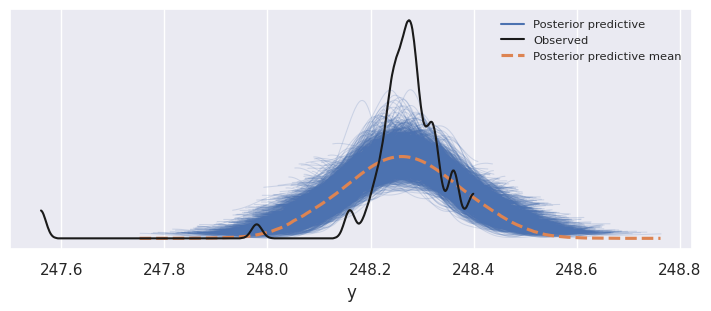

In [18]:
# plot_ppc shows the overlay of density estimates of the actual data set (solid) and the simulated data sets.
# The average of the simulated densities is also shown.
# The simulated datasets have too low densities in the center.
# The variance of the normal normal model is too large, and the model provides a poor fit.
# The variance is inflated by outliers. Indeed, the normal model and the normal distribution
# in general is not robust when dealing with outliers.
az.plot_ppc(ppc);

#  Robust models

* Outliers are observations which are  far from the mean  and isolated from the other ones.

* These points could be due to experimental errors. While we could remove them from the data, this is unavoidably arbitrary; we cannot validate the criterion used to detect outliers.

* A more rigorous approach is to adopt a *heavy-tailed* (or *long-tailed*) likelihood which allows some probability also to observations which are far from the mean (i.e., beyond the range $\mu \pm 3 \sigma$). This is a  *robust* model.

* The $t$ distribution is a robust alternative to the normal distribution.


#  The normal distribution has light tails

* The normal distribution is  sensitive to outliers, since
the density  is practically 0 outside  $\mu \pm 3 \sigma$.


* If the data set contains observations very far from the mean, the normal model  inflates the variance to include them within the $\mu \pm 3 \sigma$ interval.

# Student's t distribution


* It is characterized by  mean $\mu$,   scale $\sigma$  and  *degrees of freedom*  (or  *normality* coefficient) $\nu$.

*  $\nu$ controls the length of the tails. Low values of $\nu$ correspond to heavy tails.

    * $\nu = 4$ is a common choice to deal with outliers;
      * lower values of $\nu$ are *not* recommended;

    * for $\nu < 10$ the distribution remains *heavy tailed*;
    
    *  $\nu > 30$: the Student is practically equivalent to a Gaussian.

    
    

    * The Student pdf decays as a polynomial function of the squared distance from the center, while the normal decreases exponentially.

# normal vs t distribution

* Consider a standard distribution with $\mu=0, \sigma=1$.

* The table shows how the lenght of the tails decreases with larger $\nu$.

|  |  Student ($\nu$=4) | Student ($\nu$=10) | Student ($\nu$=30) | N(0,1) |
|:-:| :-: | :-: | :-: | :-: |    
| qtile .995 | 4.6 | 3.2 | 2.7 | 2.6 |

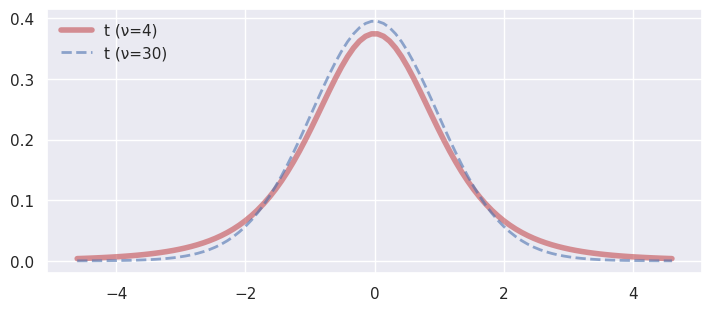

In [19]:
# Visually:
# - the t density (nu=30, close to the normal) is 0 at about 3 sigma from the mean.
# - the t density (nu=4) is 0 at about 4 sigma from the mean.

from scipy.stats import t
x = np.linspace(t.ppf(0.005, 4),
                t.ppf(0.995, 4), 100)
plt.plot(x, t.pdf(x, 4),
       'r-', lw=4, alpha=0.6, label='t (ν=4)')
plt.plot(x, t.pdf(x, 30),
       'b--', lw=2, alpha=0.6, label='t (ν=30)')
plt.legend(loc="upper left");

# Comparing the normal and the Student-t distribution


* To match the high quantiles (.975, .995) of the Student($\nu$=4) with a Gaussian we need to increase much its standard deviation. However this way the normal distribution becomes very spread and low around the mean.


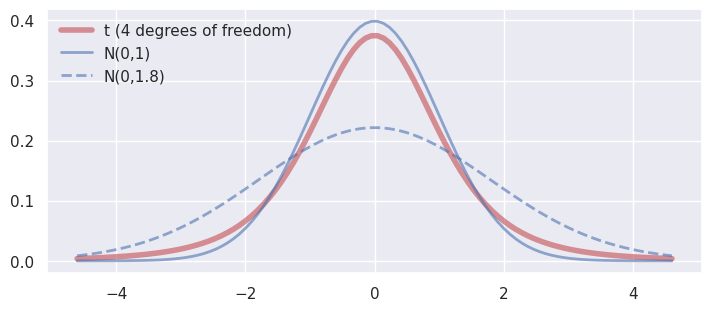

In [20]:
from scipy.stats import t
x = np.linspace(t.ppf(0.005, 4),
                t.ppf(0.995, 4), 100)
plt.plot(x, t.pdf(x, 4),
       'r-', lw=4, alpha=0.6, label='t (4 degrees of freedom)')
plt.plot(x, norm.pdf(x),
       'b-', lw=2, alpha=0.6, label='N(0,1)')
plt.plot(x, norm.pdf(x, scale = 1.8),
       'b--', lw=2, alpha=0.6, label='N(0,1.8)')
plt.legend(loc="upper left");

# Robust  model

\begin{align*}
\mu &\sim N(\mu', \sigma_{\mu}) && \text{prior on  } \mu\\
\sigma &\sim \text{Half-Normal}(\xi) && \text{prior on } \sigma \\
y & \sim StudentT (\mu, \sigma, \nu=4) && \text{robust model of the observations}
\end{align*}

In [21]:
with pm.Model() as robust_model:
    #the priors are the same as those of  the first variant
    mu_t    = pm.Normal('mu_t', 240, 80)
    sigma_t = pm.HalfNormal('sigma_t', sigma=3)

    #robust likelihood
    y       = pm.StudentT('y', mu=mu_t, sigma=sigma_t, nu=4, observed=data)

    #prediction for a new measurement
    #prediction = pm.StudentT('prediction', mu=mu_t, sd=sigma_t, nu=4)

    robust_trace = pm.sample(return_inferencedata=True)

Output()

In [22]:
# The estimate of mu is  identical between the model with normal and t likelihood,
# but the model with t likelihood has much lower sigma than the normal model.
# The t distribution does not inflate the variance to cover the outliers.

with robust_model:
    summary_t = az.summary(robust_trace)
with normal_model:
    summary= az.summary(normal_trace)
pd.concat([summary, summary_t])[ ["mean","sd" ]]

,mean,sd
mu,248.261,0.014
sigma,0.109,0.010
mu_t,248.275,0.007
sigma_t,0.047,0.006


Output()

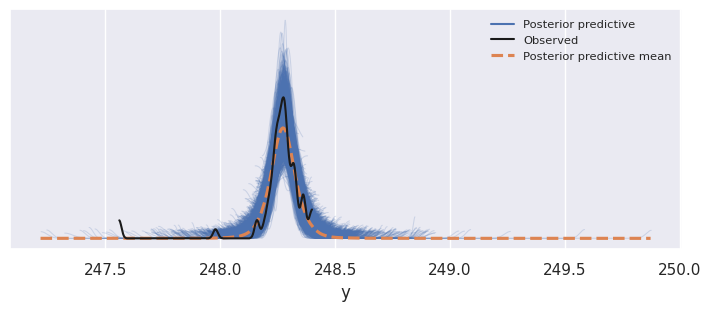

In [23]:
# The t, having smaller sigma, provides higher density around the bulk of the data.

with robust_model:
    ppc_t = pm.sample_posterior_predictive(robust_trace, model=robust_model)
az.plot_ppc(ppc_t);

# Conclusions

* The posterior predictive check has allowed to improve the model by switching to a robust $t$ likelihood.

* Dealing with another data set, how to choose between the normal and the robust likelihood?

* In few lectures we will see how to perform *model selection*, i.e., how to choose among competing models.

# Your turn - 1

* compare the predictive distribution for the next value $y^{new}$,  using the normal and the robust likelihood


* hint: use the function `t.rvs` to sample from a Student-t distribution with 4  degrees of freedom.

## Your turn - 2

* Implement a code which perform posterior predictive check for the normal and the robust model.

* For simplicity we generate 6 artificial data sets rather than a data set for each parameter sample.

* Randomly choose 6 parameter samples. For each sample a plot compare the density of the simulated data and the actual data.



# Solutions

## Predictive distribution from the beta-binomial model

In [24]:
from scipy.stats import beta
from scipy.stats import binom


# posterior samples of theta, representing epistemic uncertainty
theta_post = beta.rvs (a=15, b=20, size=2000)
s = 5 # five draws for each sample of theta
n = 20 # future trials

new_successes = np.zeros( len(theta_post) * s)

#this sampling represent the aleatory uncertainty
# each drawn value of y_new is an integer, comprised between 0 and 20 (the number of future trials)
for i, t in enumerate(theta_post):
        new_successes[i*s : (i+1) * s] = binom.rvs(n=n, p=t, size=s)

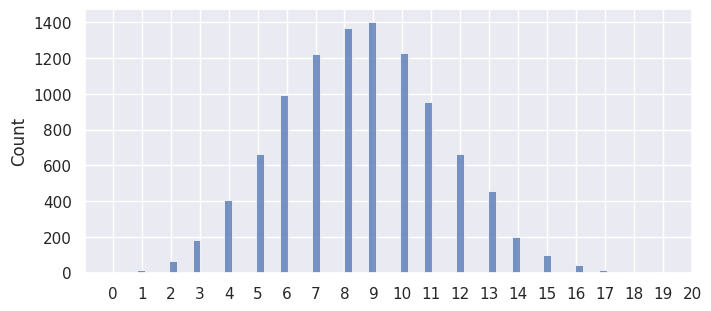

In [25]:
# plotting the predictive distribution
# we plot using an histogram, since the distribution is discrete.
# since the distribution is symmetric, we compute the HDI by taking the 2.5 and 97.5 quantile.
sns.histplot(new_successes);
plt.xticks(ticks=np.arange(0,21,1));

In [28]:
# Summary of the predictive distribution
# The most plausible outcome is 9 successes in the next 20 trials, but the 95% HDI
# shows a major uncertainty, going from 4 to 14.
pd.DataFrame( new_successes ).describe( percentiles=[0.025, 0.975] )

,0
count,10000.000000
mean,8.584800
std,2.757675
min,0.000000
2.5%,3.000000
50%,9.000000
97.5%,14.000000
max,19.000000


## Predictive distribution of the normal and the robust model

In [29]:
from scipy.stats import t
# samples from the normal model
post_samples_normal = az.extract(normal_trace.posterior)
mu_post_normal      = post_samples_normal.mu.values
sigma_post_normal   = post_samples_normal.sigma.values

# samples from the robust model
post_samples_t = az.extract(robust_trace.posterior)
mu_post_t = post_samples_t.mu_t.values
sigma_post_t = post_samples_t.sigma_t.values

# we draw five values for each pair of mu and sigma values.
# This provides  a smoother predictive distribution.
s = 5 #number of y_new sampled  for each element of the trace.

#your code: compute a probabilistic prediction for the next observation
s = 5 #number of y_new sampled  for each element of the trace.
y_new_normal = np.zeros( len(mu_post) * s)
y_new_t = np.zeros( len(mu_post) * s)

#we should use together  the values of sigma e mu referrring to the same sample
for i, current_mu in enumerate(mu_post):
        y_new_normal[i*s : (i+1) * s] = np.random.normal (loc = mu_post_normal[i], scale = sigma_post_normal[i], size=s)
        y_new_t[i*s : (i+1) * s] = t.rvs (loc = mu_post_t[i], scale = sigma_post_t[i], df=4, size=s)


predictive = pd.concat([pd.DataFrame(y_new_normal), pd.DataFrame(y_new_t)], axis=1)
predictive.columns = ['normal', 'robust']

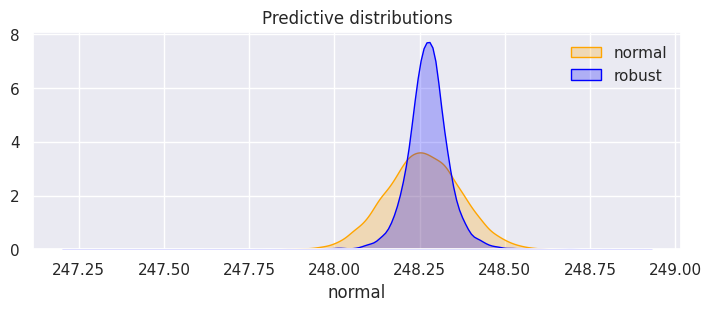

In [30]:
#here we visually compare the predictive distribution of the model with Gaussian and  Studend likelihood.
#the t distribution has higher density around the mean; at the same time it has  longer tails.

sns.kdeplot(predictive['normal'], color='orange', fill=True, label='normal');
sns.kdeplot(predictive['robust'], color='blue', fill=True, label='robust');
plt.title('Predictive distributions')
plt.ylabel('')
plt.yticks(labels=None)
plt.legend();

## Posterior predictive check with the normal and the robust model

* For simplicity we generate 15 artificial data sets rather than a data set for each parameter sample.


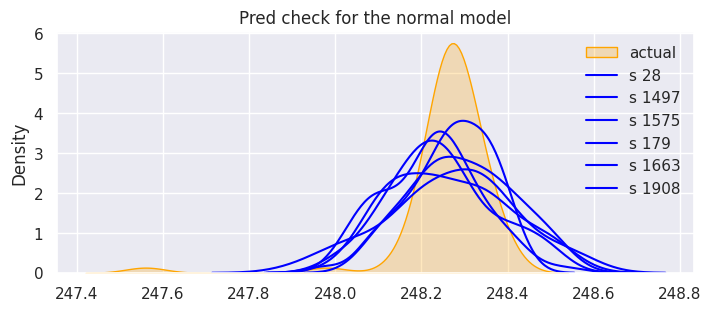

In [31]:
# sample from the normal model


tot_samples = mu_post_normal.shape[0]
pp_samples = 6
idx = np.random.randint(0, tot_samples, pp_samples)

# kdeplot of the actual data
sns.kdeplot(data, color='orange', label='actual', fill= True);
plt.title( 'Pred check for the normal model')

# for each drawn samples, generate a data set of size 66 and plot its density
for i, current_idx in enumerate(idx):
  y_new = np.random.normal(loc = mu_post_normal[current_idx], scale = sigma_post_normal[current_idx], size=66)
  sns.kdeplot(y_new, color='blue', label= 's ' + str(current_idx));
  plt.legend();


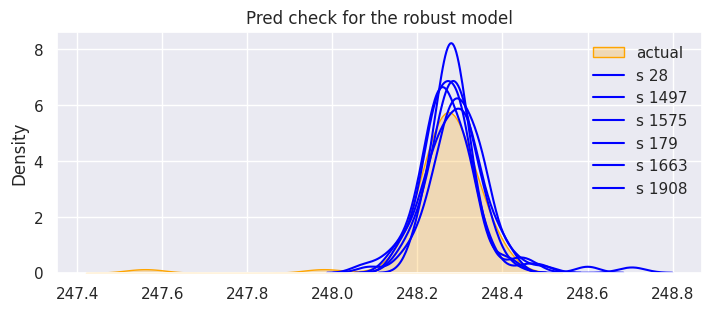

In [32]:
# sample from the robust model
# we use the same random index as before
from scipy.stats import t

# kdeplot of the actual data
sns.kdeplot(data, color='orange', label='actual', fill= True);
plt.title( 'Pred check for the robust model')

# for each drawn samples, generate a data set of size 66 and plot its density
for i, current_idx in enumerate(idx):
  y_new = t.rvs (loc = mu_post_t[current_idx], scale = sigma_post_t[current_idx], df=4, size=66)
  sns.kdeplot(y_new, color='blue', label= 's ' + str(current_idx));
  plt.legend();